# CNN Cancer Kaggle Competition

**Step 1: Brief description of the problem and data**

**Load and describe the dataset, problem statement, and objectives**

Data and libraries are imported. This includes the training labels, sample submission, and the images (train, validation, test)

This data comes from histodataset, which uses histological images to identify metastatic tissue in scans of lymph node sections. The dataset has csv files for training labels and for a sample submission. There are training and validation images of cancer vs non cancer cells and the solution will classify the sample submission. I chose to also use a dataset which took a subset of images to train (10,000 and 50,000) because the dataset may be too big otherwise and this cuts down on computation time.

On this problem we will use a convolution neural network which is a suitable deep learning algorithm for this type of visual data 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook
import os

        
#Input Datasets CNN Cancer Detection
path = '/kaggle/input/histo-dataset/histo_dataset/'
train_path = f'{path}/train'
test_path = f'{path}/test'


train_labels_path = '/kaggle/input/histo-dataset/histo_dataset/train_labels.csv'
path_histo = f'/kaggle/input/histo-dataset/histo_dataset'

# Load train_labels.csv and sample_submission.csv
train_labels = pd.read_csv('/kaggle/input/histo-dataset/histo_dataset/train_labels.csv')
train_labels.set_index('id', inplace=True)



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Step 2: Exploratory Data Analysis (EDA)
# Visualize and clean the data

**Perform exploratory data analysis, visualize histograms, etc.**
**Clean the data if necessary (e.g., handle missing values)**

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

This code utilized the data training set from Borbolla Alejandro 195004 and Dubois Hugo 195347 (https://www.kaggle.com/code/alejandroborbolla/histopathologic-cancer-detection/notebook) and broke the code down into 10,000 and 50,000 images to filter out some of the data instead of using all images. For each subset, there is a training and test set, where the training set is 80% of the subset.

For each training and test set there are two catagories:cancer and non_cancer

First, the data is imported, then the info and head is displayed to show null counts


In [2]:
#Clean Data

#visualize data
print(train_labels.info())
print(train_labels.head())


<class 'pandas.core.frame.DataFrame'>
Index: 220025 entries, f38a6374c348f90b587e046aac6079959adf3835 to a81f84895ddcd522302ddf34be02eb1b3e5af1cb
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   label   220025 non-null  int64
dtypes: int64(1)
memory usage: 3.4+ MB
None
                                          label
id                                             
f38a6374c348f90b587e046aac6079959adf3835      0
c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
755db6279dae599ebb4d39a9123cce439965282d      0
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
068aba587a4950175d04c680d38943fd488d6a9d      0


Then the datase is cleaned by checking for missing values. There were no NaN values in the dataset so no further action was taken

In [3]:
# Checking for missing values
missing_values = train_labels.isnull().sum()
print("Number of missing_values:",missing_values)

Number of missing_values: label    0
dtype: int64


Next, the data was visualized through a histogram of the count for positive v negative samples (cancer (1) v non cancer (0))

This showed that the cancer (1) dataset was much smaller than the non-cancer dataset (0). Further cleaning is necessary to even the distribution of images used in this analysis. The code was filtered out to the subsets in the Histo dataset which contain 10,000 images and 50,000 images to narrow down the data. This was modeled after the dataset used in alejandroborbolla submission. Ultimately the entire dataset was used and not the subset, but this was informative for hyper-parameter tuning which requires quicker processing to find the best model architecture. https://www.kaggle.com/code/alejandroborbolla/histopathologic-cancer-detection/notebook

In [4]:
#additional file paths with 10,000 and 50,000 images filtered train and val for cancer/noncancer
base_test_test_path = f'{path_histo}/test'
base_test_train_10000_path = f'{path_histo}/10000/train'
base_test_train_50000_path = f'{path_histo}/50000/train'
base_test_train_all_path = f'{path_histo}/all/train'
base_test_valid_10000_path = f'{path_histo}/10000/valid'
base_test_valid_50000_path = f'{path_histo}/50000/valid'
base_test_valid_all_path = f'{path_histo}/all/valid'

image_size = 96
test_batch_size = 32
model_file = 'model.h5'

#train_labels = pd.read_csv('/kaggle/input/histo-dataset/histo_dataset/train_labels.csv')



The ImageDataGenerator class is used from keras is used which reads images from folders using the function flow_from_directory(). The class parameters specify labels of cancer with 1 and non-cancer with 0

The pixels are normalized and rescaled converting the range 0-255 to 0-1.This ensures that each image contributes to the total loss evenly and processes it faster.

In [5]:
# rescale normalize data
datagen = ImageDataGenerator(rescale=1.0/255)

# Train dataset
train_gen = datagen.flow_from_directory(base_test_train_all_path,
                                        target_size=(image_size,image_size),
                                        batch_size=test_batch_size,
                                        class_mode='categorical',
                                        classes= {'non_cancer': 0, 'cancer': 1},)

# Valid dataset
valid_gen = datagen.flow_from_directory(base_test_valid_all_path,
                                        target_size=(image_size,image_size),
                                        batch_size=test_batch_size,
                                        class_mode='categorical',
                                        classes={'non_cancer': 0, 'cancer': 1},)



Found 176020 images belonging to 2 classes.
Found 44005 images belonging to 2 classes.


Plot a histogram of cancer (1) v non-cancer (0) to show distribution. The distribution is pretty balanced so no further processing was done

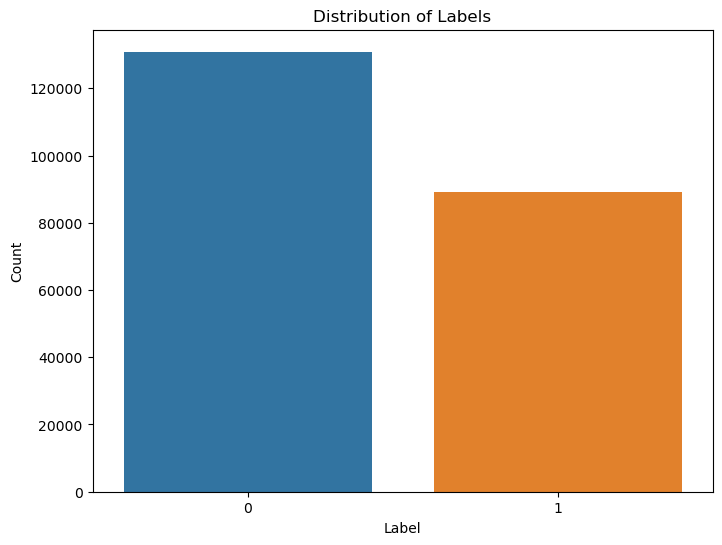

In [6]:
# histogram
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_labels)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Step 3 DModel Architecture
**Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters.**

The deep learning architecture used for this project will be CNN a Convolution Neural Network. This works by taking an input image and deciphering features and then classifying the features. This involves a number of convolutional subsampling layers. The input takes the height, width, and RGB channels of an image. Then it has kernels which are convoluted with the image to produce a feature map. The maps are then subsampled and pooled with an additive bias and activation function for each map. It also features a backpropagation through the connected layers.

A dropout layer is used to prevent overfitting by disabling some neurons. 

ReLU was chosen as the activation function (Rectified Linear Activation) because it handles non-linearity and is computationally effective with its simple thresholding operation.This is also a good function for gradients


In [17]:
# Building the CNN Model
from tensorflow.keras.layers import BatchNormalization


# Split data into training and validation sets
train_data, val_data = train_test_split(train_labels, test_size=0.25, random_state=42)

# Step 3: Model Architecture
# Build and train CNN models
num_train_samples = len(train_gen)
num_val_samples = len(valid_gen)

train_steps = np.ceil(num_train_samples / test_batch_size)
val_steps = np.ceil(num_val_samples / test_batch_size)


# Define the CNN model architecture
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# calculate the size of the flattened layer after max-pooling
flattened_size = model.output_shape[1] * model.output_shape[2] * model.output_shape[3]

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 94, 94, 64)        1792      
                                                                 
 batch_normalization_9 (Batc  (None, 94, 94, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 47, 47, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 47, 47, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 128)       73856     
                                                                 
 batch_normalization_10 (Bat  (None, 45, 45, 128)     

Keras features a compile() function and the following parameters were set
Optimizer:adam
This is a SGD stochastic gradient descent optimization

Loss function: binary_crossentropy for binary classification

metrics: accuracy

In [21]:
# Compiling with Keras
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
# Train the model
num_epochs=3
history = model.fit(train_gen, validation_data=valid_gen, epochs=num_epochs)

for epoch in range(num_epochs):
    avg_val_loss = history.history['val_loss'][epoch]
    print(f'Epoch {epoch+1}/{num_epochs} - Avg. Val Loss: {avg_val_loss:.4f}')

Epoch 1/3


2023-08-27 07:26:43.772439: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


5501/5501 [==============================] - 641s 116ms/step - loss: 0.3800 - accuracy: 0.8450 - val_loss: 0.3948 - val_accuracy: 0.8353
Epoch 2/3
5501/5501 [==============================] - 406s 74ms/step - loss: 0.3003 - accuracy: 0.8802 - val_loss: 0.2719 - val_accuracy: 0.8888
Epoch 3/3
3021/5501 [===============>..............] - ETA: 2:21 - loss: 0.2712 - accuracy: 0.8919

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Perform hyperparameter tuning, try different architectures

2042/5501 [==========>...................] - ETA: 15:15 - loss: 7.8396 - accuracy: 0.5551. model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

flattened_size = model.output_shape[1] * model.output_shape[2] * model.output_shape[3]

model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='relu'))

**Change dropout rate to 0.25, change dense to 512, and more complex layers starting at 64 to 256 instead.**

5501/5501 [==============================] - ETA: 0s - loss: 0.4093 - accuracy: 0.8385

**Add epoch to 3**
Epoch 1/3
5501/5501 [==============================] - 641s 116ms/step - loss: 0.3800 - accuracy: 0.8450 - val_loss: 0.3948 - val_accuracy: 0.8353
Epoch 2/3
5501/5501 [==============================] - 406s 74ms/step - loss: 0.3003 - accuracy: 0.8802 - val_loss: 0.2719 - val_accuracy: 0.8888
Epoch 3/3
3021/5501 [===============>..............] - ETA: 2:21 - loss: 0.2712 - accuracy: 0.8919



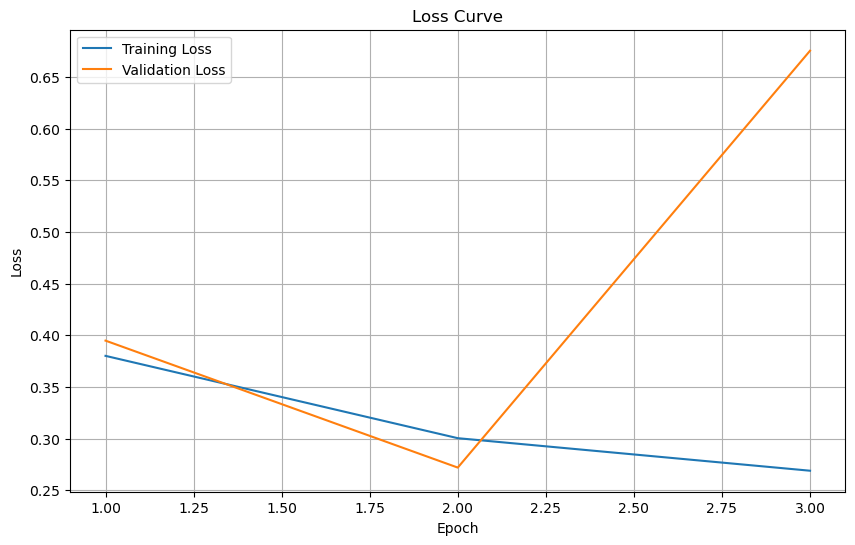

In [35]:

# Step 4: Results and Analysis
from sklearn.metrics import confusion_matrix
# Analyze training results, generate tables and figures

# Get the loss values from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_loss, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()



# Discuss why certain choices worked well and troubleshoot any issues

After 2 epochs, the loss in the validation data went up and the training loss slope slightly decreased. The best results after hyperparameter tuning occurred using a learning rate of 0.001, adam optimizer, and the below architecture.  Dropout of 0.25 worked well in comparison to other methods tried, and a softmax activation in the last dense layer. Batch normalization also proved to be helpful for faster training. The final model had good accuracy, minimal loss and fast training as compared to previous iterations. 

Model architecture for best results:
 conv2d_9 (Conv2D)           (None, 94, 94, 64)        1792      
                                                                 
 batch_normalization_9 (Batc  (None, 94, 94, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 47, 47, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 47, 47, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 128)       73856     
                                                                 
 batch_normalization_10 (Bat  (None, 45, 45, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 22, 22, 128)      0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 22, 22, 128)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 256)       295168    
                                                                 
 batch_normalization_11 (Bat  (None, 20, 20, 256)      1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 10, 10, 256)      0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 10, 10, 256)       0         
                                                                 
 flatten_3 (Flatten)         (None, 25600)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               13107712  
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                 1026   

# Step 5: Conclusion
 **Summarize results, learnings, and takeaways**
 
 Overall, the model had good accuracy ~89% by the third epoch, and this could be a reasonable diagnostic tool for histological cancer classification. This was evaluated using loss and accuracy outputs. 

 
 **Reflect on improvements and future directions for the project**
 
 In the future, it may work well to use other optimizations. More epochs or increasing layers and model complexity also could improve accuracy, but choosing this architecture allowed the model to run quickly to best evaluate the differences in hyper-parameter tuning. 89% accuracy as a diagnostic tool is still relatively low and would require more tests to be run in order to classify a patient case. When it comes to delievering a patient a diagnosis of cancer/non-cancer it is necessary to be extremely accurate. 

References:
https://www.tensorflow.org/tutorials/images/cnn
https://www.kaggle.com/code/conradkleykamp/histopathologic-cancer-detection-cnn-keras
https://www.kaggle.com/code/alejandroborbolla/histopathologic-cancer-detection/notebook
https://www.kaggle.com/code/xreina8/histopath-79-44-accurate-ai-cancer-detection